In [319]:
import keras
import lime
import os
import random
import cv2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.preprocessing.image import load_img, img_to_array
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.color import label2rgb
from lime import lime_image
from PIL import ImageFilter, ImageEnhance, Image
from skimage.segmentation import mark_boundaries


np.random.seed(42)
random.seed(42)


class LimeAnalyser:
    def __init__(self):
        self._data = pd.read_csv('all_outputs.csv')
        self._tagged_data_path = '/home/mdrzewiecki/mim/BreastCancerAnalysis/data/'
        self._choose_tagged_sample()
        self._setup_sample_files()
        self._setup_explainer()
        self._positive_label = "Cancer"
        self._negative_label = "Healthy"
        
    @property
    def x(self):
        return self._x
    
    @property
    def y(self):
        return self._y
    
    @property
    def model(self):
        return self._model
    
    @property
    def segmenter(self):
        return self._segmenter
    
    def pred_fn(self, sample):
        return self._model.predict(sample)
    
    def explain_tagged_files(self, num_samples):
        selected_ids = np.random.randint(0, 1000, num_samples)
        _, sample_file_name = os.path.split(self._chosen_image_path)
        image = Image.open(self._chosen_image_path)
        ground_truth = Image.open(self._chosen_image_ground_truth)
        for i in selected_ids:
            print(f"file: {sample_file_name}, sample: {i}")
            
            image_part = image.crop((i, i, i + 50, i + 50))
            ground_truth_part = ground_truth.crop((i, i, i + 50, i + 50))
            ground_truth_part = ground_truth_part.resize((360, 360))
            image_part = np.array(image_part)
            
            explanation = self._explainer.explain_instance(
                image_part, self.pred_fn, top_labels=5, num_samples=500, segmentation_fn=analyzer.segmenter, hide_color=0)
            print(explanation.local_exp)
            temp, mask = explanation.get_image_and_mask(
                explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.001)
                                
            explanation_img = Image.fromarray(temp.astype(np.uint8))
            explanation_img = explanation_img.resize((360, 360))
            result = Image.fromarray(np.hstack((np.array(explanation_img),np.array(ground_truth_part))))
            display(result)
                        
            print("========================================================")
            
    
    def explain_sample_files(self, num_samples=500):
        explanation = explainer.explain_instance(
            analyzer.x[0], 
            classifier_fn=analyzer.model.predict,
            top_labels=2,
            hide_color=0, 
            num_samples=num_samples, 
            segmentation_fn=analyzer.segmenter)
        temp, mask = explanation.get_image_and_mask(analyzer.y[0], positive_only=True, num_features=5, hide_rest=False)
        fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
        ax1.imshow(mask,temp, interpolation = 'nearest')
        ax1.set_title('Positive Regions for {}'.format(analyzer.y[0]))
        temp, mask = explanation.get_image_and_mask(y[0], positive_only=False, num_features=10, hide_rest=False)
        ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
        ax2.set_title('Positive/Negative Regions for {}'.format(analyzer.y[0]))
    
    def _choose_tagged_sample(self):
        self._data_original_images_dir = os.path.join(self._tagged_data_path, 'images')
        self._data_ground_truth_dir = os.path.join(self._tagged_data_path, 'groundTruth_display')
        cases = next(os.walk(self._data_original_images_dir))[2]
        chosen_tagged_image = cases[random.randint(0, len(cases))]
        chosen_tagged_ground_truth = os.path.splitext(chosen_tagged_image)[0]+'.png'
        self._chosen_image_path = os.path.join(self._data_original_images_dir, chosen_tagged_image)
        self._chosen_image_ground_truth = os.path.join(self._data_ground_truth_dir, chosen_tagged_ground_truth)
    
    def _setup_sample_files(self):
        self._false_predictions = self._data.loc[(self._data["pred_y"] > 0.5) != self._data["true_y"]]
        self._false_positives = self._false_predictions.loc[self._false_predictions["pred_y"] > 0.5]
        self._false_negatives = self._false_predictions.loc[self._false_predictions["pred_y"] < 0.5]
        self._false_positive_files = self._false_positives['# file']
        self._false_negative_files = self._false_negatives['# file']
        self._false_negatives_sample = np.random.randint(0, len(self._false_negative_files), 2)
        self._false_positives_sample = np.random.randint(0, len(self._false_positive_files), 2)
        self._false_negative_sample_files = self._false_negative_files.iloc[self._false_negatives_sample]
        self._false_positive_sample_files = self._false_positive_files.iloc[self._false_positives_sample]
        self._sample_files = self._false_positive_sample_files._append(self._false_negative_sample_files)
        self._load_data(sample_files, end=4)
    
    def _load_data(self, files, start=0, end=10, augment_fn=None):
        X = []
        y = []
        for f in files[start:end]:
            print(f'LimeAnalyser._load_data(): Loading file {f}')
            img = load_img(f, target_size=(50, 50))
            if augment_fn is not None:
                sample = augment_fn(img)
            else:    
                sample = tf.convert_to_tensor(img)
            X.append(sample)
            y.append(f[-5])
        self._x = np.stack(X)
        self._y = np.array(y, dtype=float)
    
    def _setup_explainer(self):
        self._model = keras.models.load_model("../models/CanDetect.keras")
        self._explainer = lime_image.LimeImageExplainer(verbose=False)
        self._segmenter = SegmentationAlgorithm('slic', n_segments=50, compactness=1, sigma=1)

analyzer = LimeAnalyser()

LimeAnalyser._load_data(): Loading file ../data/12872/0/12872_idx5_x2401_y651_class0.png
LimeAnalyser._load_data(): Loading file ../data/10254/0/10254_idx5_x1551_y1251_class0.png
LimeAnalyser._load_data(): Loading file ../data/10303/1/10303_idx5_x951_y1351_class1.png
LimeAnalyser._load_data(): Loading file ../data/15472/1/15472_idx5_x1451_y1501_class1.png


file: Case_10-04.tif, sample: 106


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 84ms/step
{0: [(3, 0.00037972191625740737), (4, 0.0003692070644913125), (12, 0.0003674052723738102), (7, 0.0003239849744402642), (1, 0.00031755521114250476), (21, 0.00029487367606492975), (14, 0.0002754458529319977), (26, 0.00027362265612261544), (9, 0.0002633681895998945), (17, 0.000258610024270614), (22, 0.00025571623938691927), (8, 0.0002470813172772913), (24, 0.0002439115496324577), (20, 0.00024187749890261487), (16, 0.00024167459032190599), (19, 0.00024019932035677412), (10, 0.00023893746875179464), (13, 0.0002379582726222593), (11, 0.00023405547570193563), (25, 0.00021538829833294025), (2, 0.00021206026187201382), (23, 0.00020411985994052604), (15, 0.00020104586142085753), (0, 0.0001997541552720432), (5, 0.00019403757425923686), (27, 0.00015364375582260792), (6, 0.00014180886526445413), (18, 0.0001084181158782267)]}


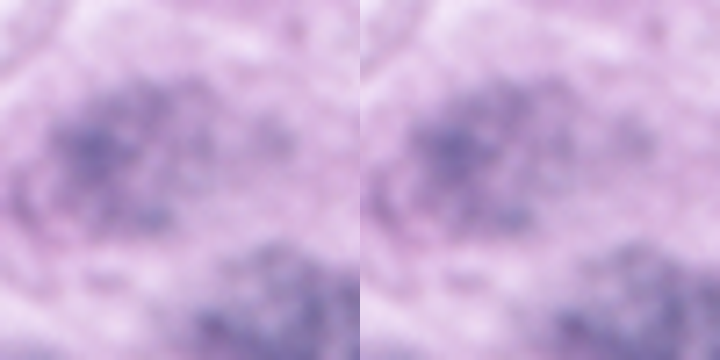

file: Case_10-04.tif, sample: 71


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 88ms/step
{0: [(8, 0.001482537637642978), (1, 0.0012805557382855016), (17, 0.001184902235285734), (7, 0.0011472959626572727), (14, 0.001117927716274564), (11, 0.0011127866451792934), (12, 0.0009963951376981864), (19, 0.000995383247527935), (16, 0.000952087898928286), (15, 0.0009093593954800205), (13, 0.0009031529241057484), (10, 0.0009029171831476478), (2, 0.0008842949563613913), (9, 0.0008828495121478535), (6, 0.0008655061774801043), (4, 0.0008549470149400524), (18, 0.0008333148042524032), (3, 0.0007972996998581162), (5, 0.0007773888008932765), (0, 0.0006491152530070013), (20, 0.0006397559509912323)]}


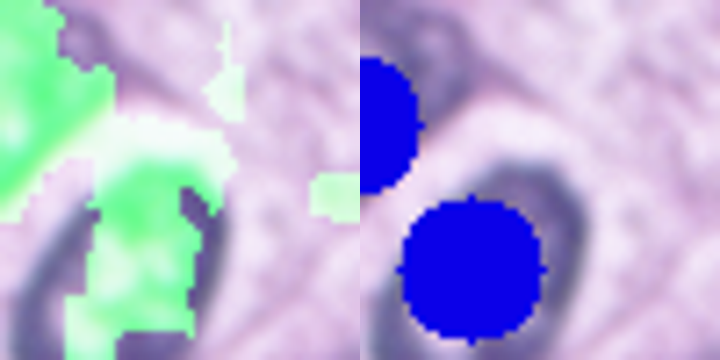

file: Case_10-04.tif, sample: 700


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 88ms/step
{0: [(12, 0.004843972083526252), (14, 0.004739673272201912), (2, 0.004561588341543209), (8, 0.004364426763660399), (9, 0.004075810639399088), (10, 0.004046620839012055), (18, 0.0039261807086686815), (5, 0.003918108622906279), (0, 0.0038431776221352298), (4, 0.0037560175344326812), (1, 0.003495423825918874), (7, 0.003446613271447074), (6, 0.0032639968031152942), (16, 0.003086712838875239), (15, 0.003054827416339622), (3, 0.003029728609858357), (13, 0.0026380143172131817), (17, 0.0024211216825675967), (19, 0.0023581057334785597), (11, 0.002279986252604358)]}


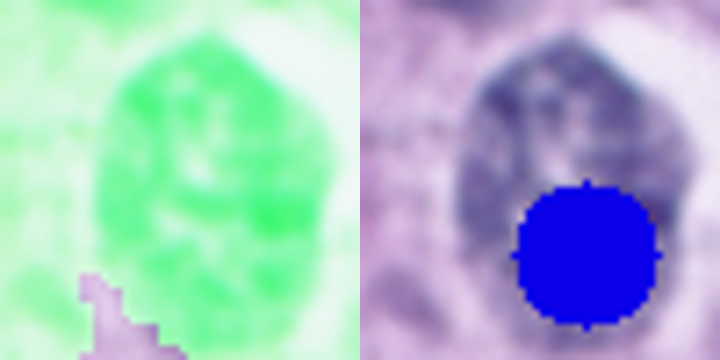

file: Case_10-04.tif, sample: 20


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 97ms/step
{0: [(1, 0.0009604291800698282), (22, 0.0009378650844978555), (7, 0.0009052846305430123), (17, 0.0008790797544861442), (0, 0.0008753588523876244), (3, 0.0008348083376072399), (6, 0.0008150385379247182), (26, 0.0007440576142126261), (9, 0.0007404091544395641), (15, 0.0007354871666555039), (19, 0.0007296101239557932), (20, 0.0007023367221630212), (5, 0.0006914002422545064), (8, 0.0006473152958991395), (4, 0.0006466829612518333), (2, 0.0006371223688525063), (12, 0.0006309590366315903), (25, 0.0006184383624107439), (18, 0.0006045162713921001), (24, 0.0005875133791260648), (13, 0.0005830935382512099), (11, 0.0005579328615319681), (10, 0.0005225206483737678), (16, 0.0005173452023023602), (21, 0.000496443115531593), (14, 0.0004412795651895356), (27, 0.00043540364362738116), (23, 0.00041260100258768963)]}


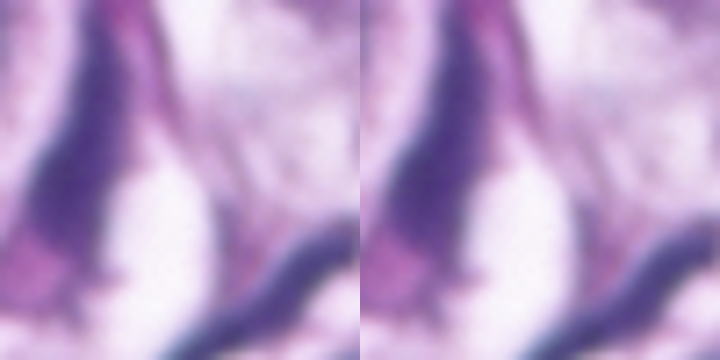

file: Case_10-04.tif, sample: 614


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 100ms/step
{0: [(27, 0.00013562580229389807), (12, 0.0001220905611123933), (9, 0.00012183335300995541), (5, 0.00011722370380350731), (6, 0.00011710379164384686), (21, 0.00011504996258107126), (4, 0.00011212933908625629), (26, 0.00011184947091870376), (8, 0.00011062552726080532), (1, 0.0001080112921883163), (20, 0.00010252641624912778), (14, 9.402118634436497e-05), (28, 9.230866344058827e-05), (23, 9.025851935478836e-05), (18, 8.872616950333917e-05), (19, 8.86734509003594e-05), (2, 8.797752548828396e-05), (25, 8.560576147504412e-05), (17, 8.49666334960035e-05), (24, 7.989513123502089e-05), (0, 7.836911609249188e-05), (10, 7.67376478066062e-05), (7, 7.575786196276774e-05), (11, 7.179261174363358e-05), (13, 7.010263641375638e-05), (3, 6.582313297591942e-05), (22, 5.580274574384001e-05), (16, 5.5022265140409854e-05), (29, 5.451110690970604e-05), (15, 3.542636879597392e-05)]}


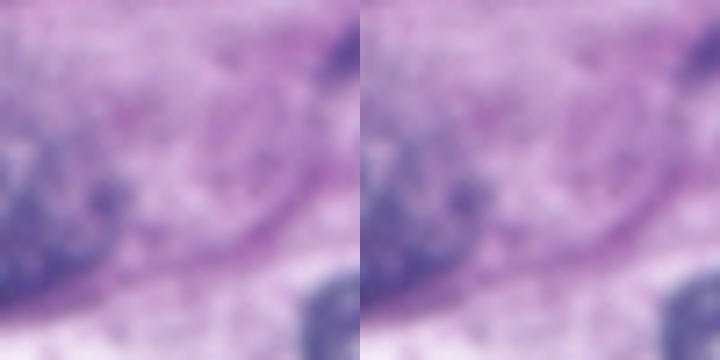

file: Case_10-04.tif, sample: 121


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 96ms/step
{0: [(18, 0.0010059487925768915), (4, 0.0009317759440673609), (23, 0.0008667963089210212), (8, 0.0008453358930120254), (20, 0.000753839628062046), (28, 0.0007135835862290584), (21, 0.0007022110176965721), (11, 0.0006921844746671515), (15, 0.000689525887662702), (9, 0.0006704713724201316), (22, 0.0006679921297459894), (10, 0.0006594180911052785), (13, 0.0006515510963816763), (24, 0.0006127530992062759), (7, 0.0006113934614557904), (5, 0.0005936596000952989), (0, 0.0005934143196608042), (6, 0.0005925966480211809), (3, 0.0005892275101854905), (29, 0.0005703783347221695), (2, 0.0005675454661088381), (25, 0.0005634487811638874), (16, 0.0005547160665564069), (26, 0.0005296304571941546), (1, 0.000522142559821968), (19, 0.000517807120225791), (27, 0.0004944620028359481), (17, 0.0004544200165970326), (12, 0.0004276159976444163), (14, 0.00039329387113245254), (30, 0.00025066024873371964)]}


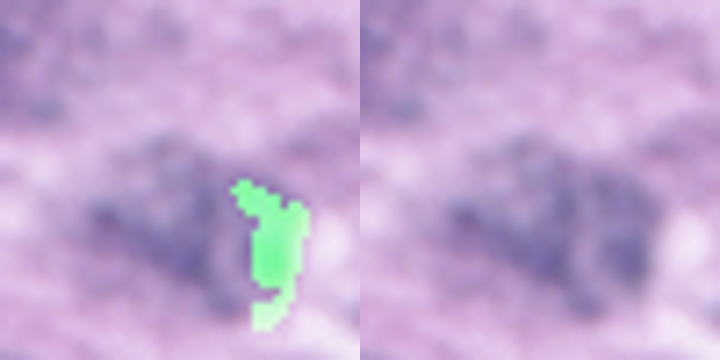

file: Case_10-04.tif, sample: 466


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 119ms/step
{0: [(7, 0.0008853340390903468), (1, 0.0008799097676636482), (0, 0.0008787138171300724), (8, 0.000820105891955995), (26, 0.0008123072141769038), (29, 0.000790606755524793), (23, 0.0007452720844382967), (18, 0.0007159865907196711), (3, 0.0007151626195134258), (6, 0.000706716945600199), (14, 0.0007036736639709327), (19, 0.0006979443941959262), (5, 0.0006977889935101082), (16, 0.0006707430598744777), (28, 0.0006497606923991117), (17, 0.0006423978548561242), (2, 0.0006377561500590349), (15, 0.0006149644990356176), (27, 0.000571923547134541), (25, 0.0005589232970925952), (12, 0.0005585225799678657), (24, 0.0005580588538844103), (22, 0.0005255434988181597), (4, 0.0005201300072933602), (13, 0.0004851672149727869), (9, 0.000448938836687687), (21, 0.00040949265467931175), (11, 0.0003791808514644911), (10, 0.0002991837079641804), (20, 0.00027723880356072774)]}


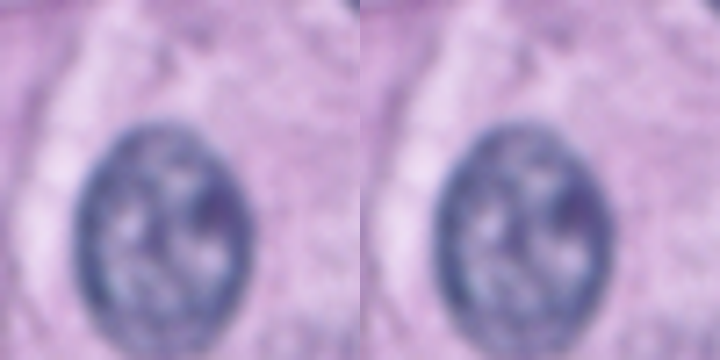

file: Case_10-04.tif, sample: 214


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 135ms/step
{0: [(4, 0.0002051089223173602), (19, 0.00019457636199146663), (12, 0.0001843662291600995), (16, 0.00016688186449949604), (3, 0.00015950987552328498), (5, 0.0001577606128445934), (17, 0.00015224033166221112), (14, 0.00014844359290296834), (0, 0.0001472688327240627), (6, 0.00013457297750512246), (2, 0.0001324555192886481), (1, 0.00012382063442992644), (9, 0.00011362650332758886), (8, 0.00011128648331066665), (15, 0.00010709240851034278), (10, 0.00010001398547811997), (13, 9.782260216004076e-05), (7, 9.722199024075742e-05), (11, 9.558189878002479e-05), (18, 8.928073363627915e-05)]}


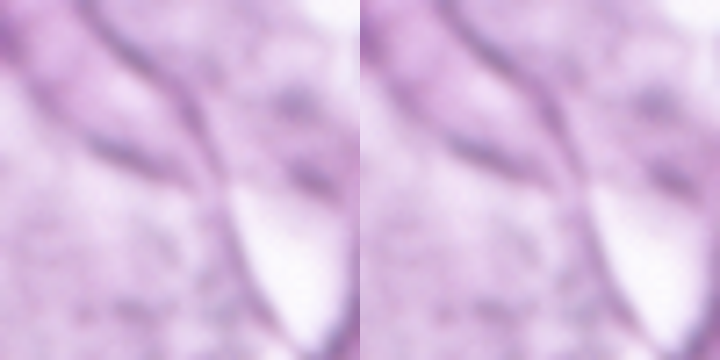

file: Case_10-04.tif, sample: 330


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 117ms/step
{0: [(7, 0.003925791568062638), (20, 0.0037582983432756074), (18, 0.003725305424450773), (2, 0.003717673611940246), (12, 0.0036368117239339347), (4, 0.0036118501641034897), (6, 0.0035227607617787887), (0, 0.003140941575473746), (23, 0.00309120149134673), (19, 0.002976999465128956), (25, 0.0028989194379065086), (26, 0.0028975883568733794), (11, 0.002879829678187598), (24, 0.0028764197048441777), (8, 0.0028424909377694554), (17, 0.0025996664167575534), (3, 0.0025495320285379183), (13, 0.002547901695280734), (21, 0.0025089809087139275), (16, 0.002419165403228048), (10, 0.0023429716588678645), (9, 0.0022569148126337394), (15, 0.002156695014716793), (22, 0.0021304957168583236), (28, 0.002121519927022733), (1, 0.002104649819057835), (14, 0.0017617483836133887), (5, 0.0014816938504453156), (27, 0.0010382765284375664)]}


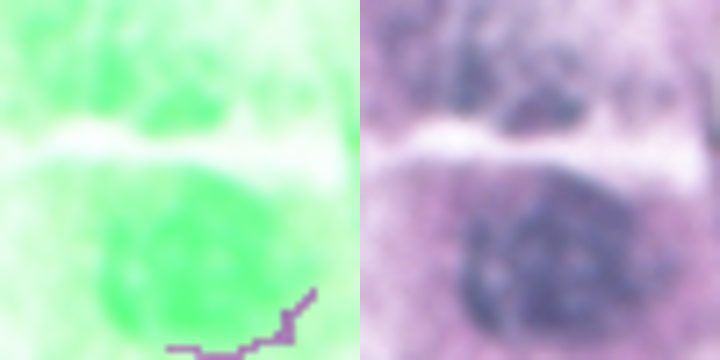

file: Case_10-04.tif, sample: 458


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 110ms/step
{0: [(17, 0.0008909141429570362), (18, 0.000865328275839434), (7, 0.0008571980201020546), (4, 0.0008053148176558237), (1, 0.0007947368387242513), (8, 0.0007840173753559787), (0, 0.0007810730514990304), (9, 0.0007519395048095784), (22, 0.0007399078589147206), (14, 0.0007154052259833202), (20, 0.0006877578765398136), (6, 0.0006826335892479398), (21, 0.0006808471257800766), (15, 0.000653739054676095), (12, 0.000630121238537936), (13, 0.0006274454025116772), (3, 0.0006153712314006815), (10, 0.0005812119843701982), (23, 0.0005454709873872647), (11, 0.0005143568296057302), (2, 0.0004997284560781287), (19, 0.0004972013237464589), (5, 0.0004343811571606115), (16, 0.00040103640084673304)]}


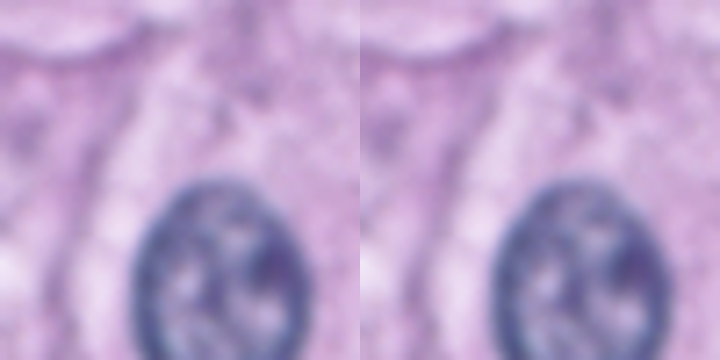

In [320]:
analyzer.explain_tagged_files(10)